# pyspark_dist_explore
______________________________

## PySpark Dataframe Distribution Explorer 

Pyspark_dist_explore is a plotting library to get quick insights on data in Spark DataFrames through histograms and density plots,  where the heavy lifting is done in Spark. 

Pypsark_dist_explore has two ways of working: there are 3 functions to create matplotlib graphs or pandas dataframes easily, and a class (Histogram) to do more advanced explorations while minimizing the amount of computation needed. 

## Functions:
* **hist(ax, x, \*\*kwargs)**. The *hist* function is almost exactly the same as the matplotlib hist function. See [here](https://matplotlib.org/examples/statistics/histogram_demo_multihist.html) for examples. The only two differences are:
    * Instead of being a function of an Axes object, an Axes object is needed as input. 
    * Instead of having an numpy array, list of arrays, or matrix as input, the function works on Spark DataFrames with a single column, a list of single-column Spark DataFrames, or a SparkDataframe with multiple columns. All other keyword arguments of the [Matplotlib hist](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.hist.html) function can be used. 


* **distplot(ax, x, \*\*kwargs)**. Combines a normalized histogram of each column in x with a density plot of the same column. 

* **pandas_histogram(x, bins=None, range=None)**. Creates histograms for all columns in x and converts this to a Pandas DataFrame

## Installing:

pyspark_dist_explore is not on PyPi yet, but you can install it easily by cloning from github:

```
git clone https://github.com/Bergvca/pyspark_dist_explore.git
cd pyspark_dist_explore
pip install .
```
### Examples



In [5]:
# Find and initialize spark
import findspark
findspark.init('/usr/lib/spark')


In [6]:
import pyspark
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML, display_html #usefull to display wide tables
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.sql import Row

sc = pyspark.SparkContext()
sqlContext = pyspark.SQLContext(sc)
%matplotlib inline

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at <ipython-input-2-9b1d61ee16cf>:20 

In [7]:
%load_ext autoreload

%autoreload 2

import pyspark
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0, '/media/chris/data/dev//PysparkDistExplore')


from IPython.display import display, HTML, display_html #usefull to display wide tables
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.sql import Row

sc = pyspark.SparkContext()
sqlContext = pyspark.SQLContext(sc)
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at <ipython-input-2-9b1d61ee16cf>:20 

In [19]:
# Create some data in a Spark DataFrame:
n_observations = 20000

random_dist_1 = np.random.logistic(100, 1000, n_observations)
random_dist_2 = np.random.logistic(400, 500, n_observations)
age_dist_1 = 20 * np.random.randn(n_observations) + 40
age_dist_2 = 15 * np.random.randn(n_observations) + 30

list_male = [('M', rand_value, age_dist_1[i]) for i, rand_value in enumerate(random_dist_1)]
list_female = [('F', rand_value, age_dist_2[i]) for i, rand_value in enumerate(random_dist_2)]

list_male_female = list_male + list_female

rdd = sc.parallelize(list_male_female)
transactions = rdd.map(lambda x: Row(gender=x[0], amount=float(x[1]), age=float(x[2])))
transactions_df = sqlContext.createDataFrame(transactions)


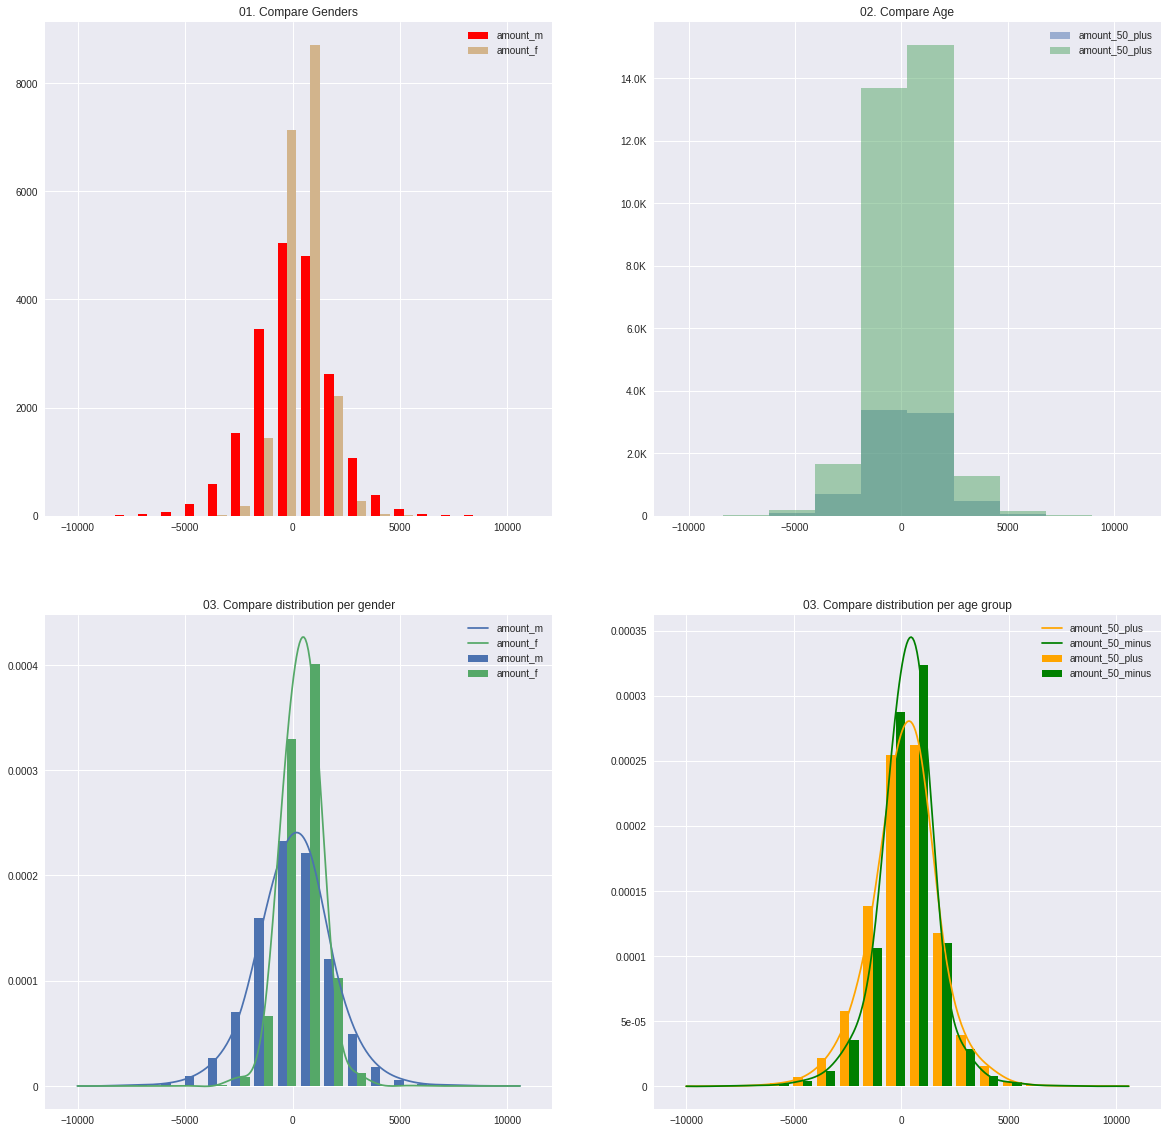

In [20]:
# Create some selections on this data

filtered_by_gender_m = transactions_df.filter(F.col('gender') == 'M').select(F.col('amount').alias('amount_m'))
filtered_by_gender_f = transactions_df.filter(F.col('gender') == 'F').select(F.col('amount').alias('amount_f') )                                                                            
filtered_by_age_50_plus = transactions_df.filter(F.col('age') > 50).select(F.col('amount').alias('amount_50_plus'))
filtered_by_age_50_minus = transactions_df.filter(F.col('age') <= 50).select(F.col('amount').alias('amount_50_minus'))                                                                             
                                                                             
# Create the plots
    
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(20, 20)

# Use the hist function to plot histograms on the Axes
hist(axes[0, 0], [filtered_by_gender_m, filtered_by_gender_f], bins = 20, color=['red', 'tan'])
axes[0, 0].set_title('01. Compare Genders')
axes[0, 0].legend()

hist(axes[0, 1], [filtered_by_age_50_plus, filtered_by_age_50_minus], overlapping=True)
axes[0, 1].set_title('02. Compare Age')
axes[0, 1].legend()

# Use the distplot function to plot (scaled) histograms + density plots on the Axes
distplot(axes[1, 0], [filtered_by_gender_m, filtered_by_gender_f], bins=20)
axes[1, 0].set_title('03. Compare distribution per gender')
axes[1, 0].legend()

distplot(axes[1, 1], [filtered_by_age_50_plus, filtered_by_age_50_minus], bins=20, color=['orange', 'green'])
axes[1, 1].set_title('03. Compare distribution per age group')
_ = axes[1, 1].legend()


In [ ]:
 # Convert Histograms of the 4 datasets to a pandas dataframe
compare_all_df = pandas_histogram([filtered_by_gender_m, 
                                    filtered_by_gender_f, 
                                    filtered_by_age_50_plus, 
                                    filtered_by_age_50_minus], 
                                   bins=20, range=(-4000, 4000))
display(compare_all_df)

## The Histogram Class

Next to running the functions as above to get results quickly, the pyspark_dist_explore library contains a Histogram class. The advantage of using this class is that it retains state, so if the histogram is build once, multiple actions can be done withouth recalculating the bin values.

### Examples

In [ ]:
age_hist = Histogram(range=(-4000, 4000), bins=15)

# Create a histogram for different age groups
for age in range(0, 90, 10):
    age_hist.add_data(
        transactions_df.
        filter((F.col('age') > age) & (F.col('age') <= age+10)).
        select(F.col('amount').alias('amount_%d_%d' % (age, age+10)))
    )

fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(20, 10)    

age_hist.plot_hist(axes[0], histtype='step', linewidth=2.0, fill=False, cumulative=True) # The Histogram is build here
age_hist.plot_density(axes[1]) # The density plot is created from the already build histogram

# Set the legends
axes[0].legend(loc = 'upper left' )
axes[0].set_title('Cumulative Histogram')
axes[1].legend()
axes[1].set_title('Kernel Density Plot')

age_hist_pd_df = age_hist.to_pandas() # Again the histograms don't need to be recalculated. 

# Create a heatmap from the Pandas Dataframe

fig, axes = plt.subplots()
fig.set_size_inches(10, 10)    
ax = sns.heatmap(age_hist_pd_df, annot=True, ax=axes)
_ = ax.set_title('Heatmap')

In [ ]:
 test_list = ['a', 'b']
rdd = sc.parallelize(test_list)
rdd_f = rdd.map(lambda x: Row(value=x))
spark_df = sqlContext.createDataFrame(rdd_f)
spark_df.show()
print(spark_df.dtypes)
print(type(spark_df.value))
print([f.dataType for f in spark_df.schema.fields])


print(isinstance(spark_df.schema.fields[0].dataType, pyspark.sql.types.StringType))

In [ ]:
 test_list = [0.1, 0.2]
rdd = sc.parallelize(test_list)
rdd_f = rdd.map(lambda x: Row(value=x))
spark_df = sqlContext.createDataFrame(rdd_f)
spark_df.show()
print(spark_df.dtypes)
print(type(spark_df.value))
print([f.dataType for f in spark_df.schema.fields])


print(isinstance(spark_df.schema.fields[0].dataType, pyspark.sql.types.NumericType))